In [25]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [26]:
# https://archive.ics.uci.edu/dataset/920/jute+pest+dataset
train_dir = 'Data/Jute_Pest_Dataset/train'
val_dir = 'Data/Jute_Pest_Dataset/val'
test_dir = 'Data/Jute_Pest_Dataset/test'

In [27]:
# Define image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 32

# Data Augmentation for Training Set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.2,1.0], 
    channel_shift_range=50.0 
)


# No Data Augmentation for Validation and Test Set
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [28]:
# Load and augment training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load validation data
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load test data
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 6443 images belonging to 17 classes.
Found 413 images belonging to 17 classes.
Found 379 images belonging to 17 classes.


In [29]:
# Calculate number of training, validation, and test samples
num_train_samples = train_generator.samples
num_val_samples = val_generator.samples
num_test_samples = test_generator.samples

# Calculate number of classes
num_classes = len(train_generator.class_indices)

# Define class labels
class_labels = list(train_generator.class_indices.keys())

# Define Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20)
reduce_lr = ReduceLROnPlateau(patience=15,verbose=0)


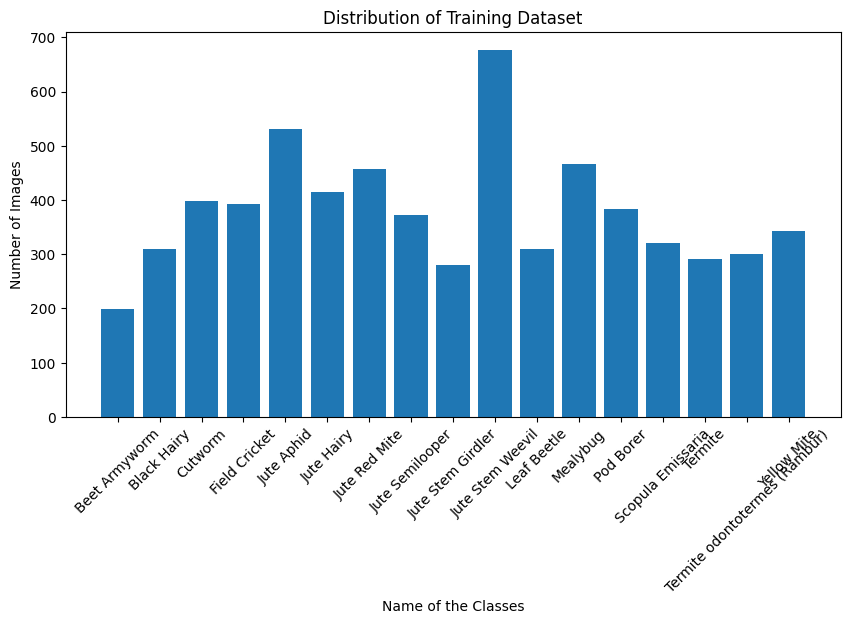

In [30]:
import matplotlib.pyplot as plt

# Calculate class distribution for training data
train_class_distribution = train_generator.classes
train_class_distribution = [train_class_distribution.tolist().count(i) for i in range(num_classes)]

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(class_labels, train_class_distribution)
plt.title('Distribution of Training Dataset')
plt.xlabel('Name of the Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

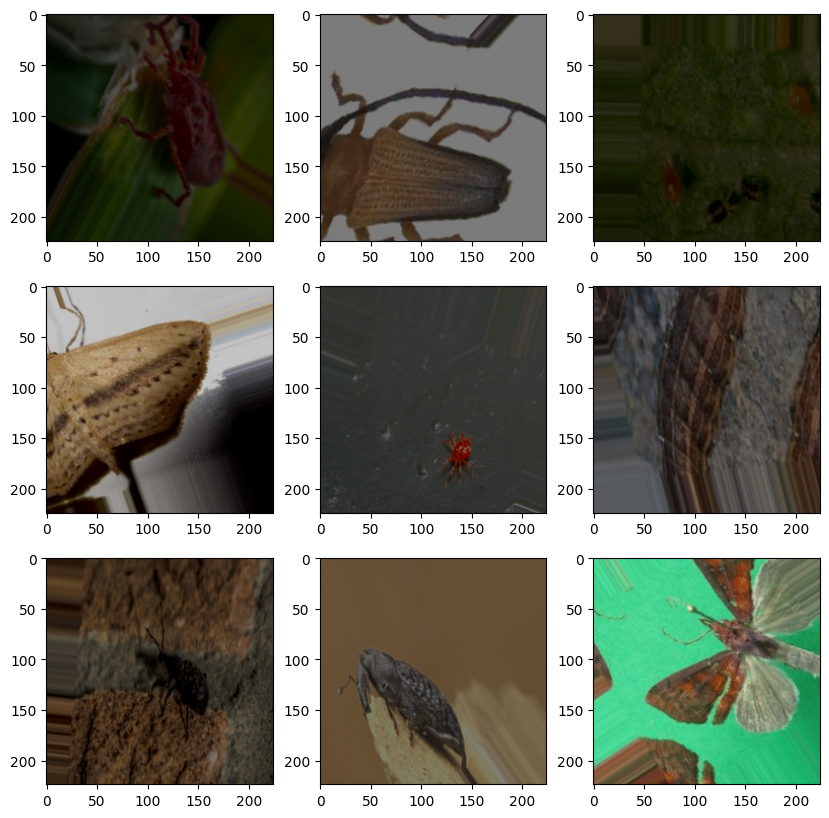

In [31]:
# Get a batch of images from the train_generator
x_batch, y_batch = train_generator.next()

# Plot 9 images from the batch
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
plt.show()

In [32]:
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(num_classes, activation='softmax')
])

# Compile the CNN model
model_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train the CNN model
history_cnn = model_cnn.fit(train_generator,
                            steps_per_epoch=num_train_samples // batch_size,
                            epochs=100,
                            validation_data=val_generator,
                            validation_steps=num_val_samples // batch_size,
                            callbacks=[early_stopping,reduce_lr])

Epoch 1/100
201/201 [==============================] - 73s 320ms/step - loss: 3.0180 - accuracy: 0.1487 - val_loss: 3.3847 - val_accuracy: 0.0625 - lr: 0.0010
Epoch 2/100
201/201 [==============================] - 63s 311ms/step - loss: 2.4556 - accuracy: 0.2497 - val_loss: 3.1312 - val_accuracy: 0.1302 - lr: 0.0010
Epoch 3/100
201/201 [==============================] - 61s 300ms/step - loss: 2.1799 - accuracy: 0.3115 - val_loss: 1.8992 - val_accuracy: 0.4505 - lr: 0.0010
Epoch 4/100
201/201 [==============================] - 63s 311ms/step - loss: 2.0168 - accuracy: 0.3572 - val_loss: 1.9649 - val_accuracy: 0.4818 - lr: 0.0010
Epoch 5/100
201/201 [==============================] - 67s 331ms/step - loss: 1.8421 - accuracy: 0.4121 - val_loss: 2.3643 - val_accuracy: 0.3281 - lr: 0.0010
Epoch 6/100
201/201 [==============================] - 66s 326ms/step - loss: 1.7279 - accuracy: 0.4367 - val_loss: 1.8810 - val_accuracy: 0.4427 - lr: 0.0010
Epoch 7/100
201/201 [=========================

In [33]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_3 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 111, 111, 64)      18496     
                                                                 
 batch_normalization_4 (Batc  (None, 111, 111, 64)     256       
 hNormalization)                                                 
                                                        

In [34]:
# Evaluate CNN model
score_cnn = model_cnn.evaluate(test_generator, steps=num_test_samples // batch_size, verbose=0)
print('CNN Test loss:', score_cnn[0])
print('CNN Test accuracy:', score_cnn[1])

CNN Test loss: 0.19268538057804108
CNN Test accuracy: 0.9460227489471436


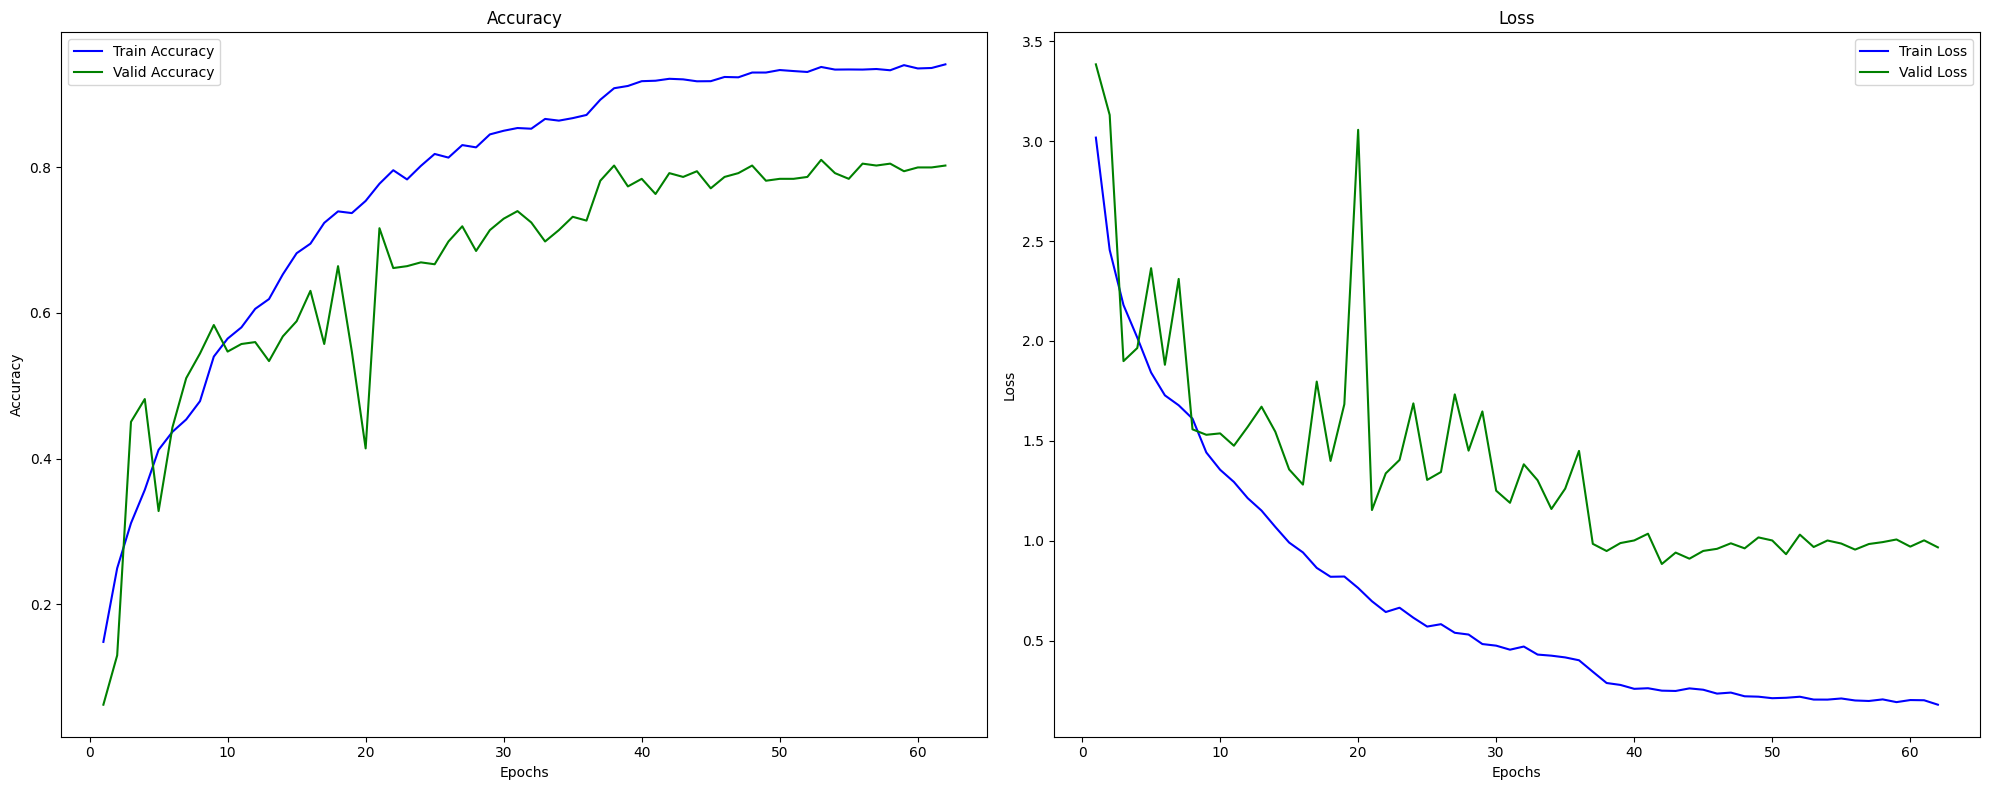

In [35]:
train_acc = history_cnn.history['accuracy']
train_loss = history_cnn.history['loss']
val_acc = history_cnn.history['val_accuracy']
val_loss = history_cnn.history['val_loss']
epochs = [i+1 for i in range(len(train_acc))]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [36]:
# Define FFNN model
model_ffnn = Sequential([
    Flatten(input_shape=(img_width, img_height, 3)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the FFNN model
model_ffnn.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Train the FFNN model
history_ffnn = model_ffnn.fit(train_generator,
                              steps_per_epoch=num_train_samples // batch_size,
                              epochs=100,
                              validation_data=val_generator,
                              validation_steps=num_val_samples // batch_size,
                              callbacks=[early_stopping])


Epoch 1/100
201/201 [==============================] - 72s 355ms/step - loss: 4.5535 - accuracy: 0.0969 - val_loss: 2.8215 - val_accuracy: 0.1719
Epoch 2/100
201/201 [==============================] - 69s 344ms/step - loss: 2.8169 - accuracy: 0.1044 - val_loss: 2.8111 - val_accuracy: 0.1719
Epoch 3/100
201/201 [==============================] - 71s 352ms/step - loss: 2.8083 - accuracy: 0.1051 - val_loss: 2.8050 - val_accuracy: 0.1693
Epoch 4/100
201/201 [==============================] - 69s 343ms/step - loss: 2.8029 - accuracy: 0.1051 - val_loss: 2.7983 - val_accuracy: 0.1797
Epoch 5/100
201/201 [==============================] - 70s 349ms/step - loss: 2.8000 - accuracy: 0.1051 - val_loss: 2.7984 - val_accuracy: 0.1693
Epoch 6/100
201/201 [==============================] - 71s 351ms/step - loss: 2.7978 - accuracy: 0.1050 - val_loss: 2.7929 - val_accuracy: 0.1745
Epoch 7/100
201/201 [==============================] - 69s 342ms/step - loss: 2.7967 - accuracy: 0.1051 - val_loss: 2.7931 -

In [37]:
# Evaluate FFNN model
score_ffnn = model_ffnn.evaluate(test_generator, steps=num_test_samples // batch_size, verbose=0)
print('FFNN Test loss:', score_ffnn[0])
print('FFNN Test accuracy:', score_ffnn[1])


FFNN Test loss: 2.858581066131592
FFNN Test accuracy: 0.06818182021379471


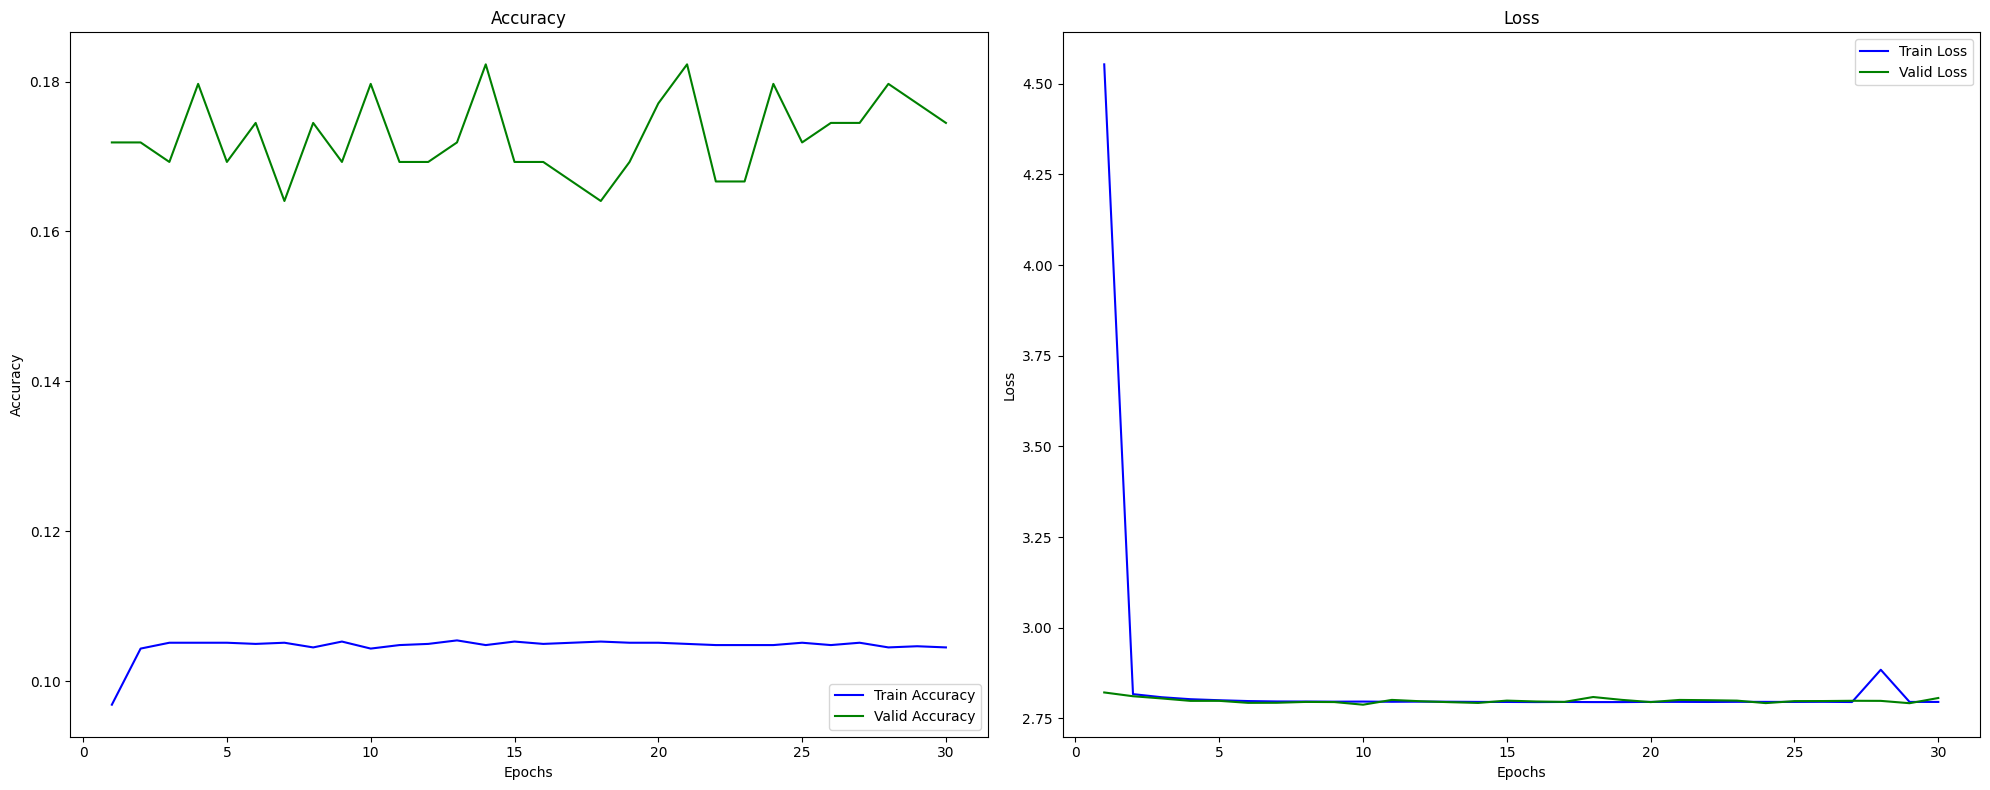

In [38]:
train_acc = history_ffnn.history['accuracy']
train_loss = history_ffnn.history['loss']
val_acc = history_ffnn.history['val_accuracy']
val_loss = history_ffnn.history['val_loss']
epochs = [i+1 for i in range(len(train_acc))]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()